In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class LayeredHeisenbergMC:
    def __init__(self, L=10, Lz=10, p_weak=0.0):
        self.L = L
        self.Lz = Lz
        self.N = L * L * Lz
        
        # Initialize Spins: Random 3D unit vectors
        # Shape: (L, L, Lz, 3)
        spins = np.random.randn(L, L, Lz, 3)
        norms = np.linalg.norm(spins, axis=3, keepdims=True)
        self.spins = spins / norms
        
        # --- LAYERED DISORDER SETUP (Eq. 2 in Paper) ---
        # J_para depends only on Z layer index
        # Strong Layer (J=1.0), Weak Layer (J=0.2)
        # p_weak is the concentration of weak layers (p in the paper)
        self.J_para = np.ones(Lz) 
        self.J_perp = np.ones(Lz) # Inter-layer coupling usually constant or correlated
        
        if p_weak > 0:
            # Randomly assign layers as "Weak"
            is_weak = np.random.rand(Lz) < p_weak
            self.J_para[is_weak] = 0.2  # Weak intra-layer coupling
            # The paper mentions J_perp can also be random, 
            # but usually J_para is the dominant effect for layered physics.
            
    def energy(self):
        """Calculate Total Energy (Hamiltonian Eq. 1)"""
        E = 0
        
        # 1. Intra-layer interactions (neighbors in x and y)
        # We vectorise this: S(r) dot S(r+x)
        Sx = np.sum(self.spins * np.roll(self.spins, 1, axis=0), axis=3)
        Sy = np.sum(self.spins * np.roll(self.spins, 1, axis=1), axis=3)
        
        # Multiply by J_para which varies by Z layer
        # J_para shape (Lz,) needs broadcasting to (L, L, Lz)
        J_broadcast = self.J_para[np.newaxis, np.newaxis, :]
        E -= np.sum(J_broadcast * (Sx + Sy))
        
        # 2. Inter-layer interactions (neighbors in z)
        Sz = np.sum(self.spins * np.roll(self.spins, 1, axis=2), axis=3)
        J_perp_broadcast = self.J_perp[np.newaxis, np.newaxis, :]
        E -= np.sum(J_perp_broadcast * Sz)
        
        return E

    def mc_step(self, T, delta=0.2):
        """Metropolis Step for Heisenberg Spins"""
        # We cannot just flip spins; we rotate them randomly.
        # Pick random sites
        for _ in range(self.N):
            x, y, z = np.random.randint(0, self.L), np.random.randint(0, self.L), np.random.randint(0, self.Lz)
            
            old_spin = self.spins[x, y, z].copy()
            
            # Propose new spin: add small random vector and re-normalize
            perturbation = np.random.uniform(-delta, delta, 3)
            new_spin = old_spin + perturbation
            new_spin /= np.linalg.norm(new_spin)
            
            # Calculate local energy change
            # Neighbors
            nbrs = (
                self.spins[(x+1)%self.L, y, z] + self.spins[(x-1)%self.L, y, z] +
                self.spins[x, (y+1)%self.L, z] + self.spins[x, (y-1)%self.L, z]
            )
            # Z-neighbors need specific J_perp handling
            # (Simplified for clarity: assuming J_perp constant for local update calculation)
            nbr_z_up = self.spins[x, y, (z+1)%self.Lz]
            nbr_z_down = self.spins[x, y, (z-1)%self.Lz]
            
            # Local H_eff
            # Note: Explicit index checking needed for varying J
            J_local = self.J_para[z]
            dE_interaction = -J_local * np.dot(new_spin - old_spin, nbrs)
            dE_z = -1.0 * np.dot(new_spin - old_spin, nbr_z_up + nbr_z_down) # Assuming J_perp=1
            
            dE = dE_interaction + dE_z

            if dE < 0 or np.random.rand() < np.exp(-dE / T):
                self.spins[x, y, z] = new_spin
                
    def simulate(self, T, steps=500):
        # Equilibration
        for _ in range(200):
            self.mc_step(T)
            
        data = []
        for _ in range(steps):
            self.mc_step(T)
            data.append(self.spins.copy())
        return np.array(data)

# --- Data Generation Strategy ---
# 1. Pure System (p_weak=0.0) -> Label 0 (Ordered) / Label 1 (Disordered)
# 2. Layered System (p_weak=0.5) -> Test Data to find Griffiths Phase

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
L = 10
Lz = 10
# Input shape: (L, L, Lz, 3)
# 3 channels correspond to Sx, Sy, Sz
model = models.Sequential([
    layers.Input(shape=(L, L, Lz, 3)),
    
    # 3D Convolution to catch spatial correlations in all directions
    layers.Conv3D(32, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax') # [P(Ordered), P(Disordered)]
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
import sys
print("Notebook is using this Python:")
print(sys.executable)

Notebook is using this Python:
c:\Users\PARAM\AppData\Local\Programs\Python\Python310\python.exe


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

def generate_large_dataset(n_samples=10000, L=10):
    """
    Generates synthetic 3D Heisenberg spin configurations for 4 classes.
    L: Linear size of the lattice (L x L x L)
    n_samples: Total number of samples to generate
    """
    X = []
    Y = []
    
    samples_per_class = n_samples // 4
    print(f"Generating {n_samples} samples ({samples_per_class} per class)...")
    
    # --- CLASS 0: STRONGLY DISORDERED (SD) ---
    # Physics: High Temp (T > Tu). Pure Paramagnetic.
    # Visual: Completely random 3D vectors.
    print("Generating Class 0: Strongly Disordered...")
    for _ in range(samples_per_class):
        # Generate random 3D vectors
        config = np.random.randn(L, L, L, 3)
        # Normalize to unit length (Heisenberg spins)
        config /= np.linalg.norm(config, axis=3, keepdims=True)
        X.append(config)
        Y.append(0)

    # --- CLASS 1: WEAKLY DISORDERED (WD) - GRIFFITHS PHASE ---
    # Physics: Tu > T > Tc. Bulk is Disordered, but Rare Strong Slabs are Ordered.
    # Visual: Random noise + A thick "slab" of aligned spins.
    print("Generating Class 1: Weakly Disordered (Griffiths)...")
    for _ in range(samples_per_class):
        config = np.random.randn(L, L, L, 3)
        config /= np.linalg.norm(config, axis=3, keepdims=True)
        
        # Create a "Rare Strong Slab" (Thickness 3 to 5 layers)
        slab_thickness = np.random.randint(3, 6)
        z_start = np.random.randint(0, L - slab_thickness)
        
        # Pick a random direction for the slab's order
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        
        # Apply order to the slab (with small thermal noise)
        slab_noise = np.random.normal(0, 0.2, (L, L, slab_thickness, 3))
        config[:, :, z_start:z_start+slab_thickness, :] = direction + slab_noise
        
        # Re-normalize the slab part
        # (We only normalize the slice we modified to keep it physical)
        slice_norm = np.linalg.norm(config[:, :, z_start:z_start+slab_thickness, :], axis=3, keepdims=True)
        config[:, :, z_start:z_start+slab_thickness, :] /= slice_norm
        
        X.append(config)
        Y.append(1)

    # --- CLASS 2: WEAKLY ORDERED (WO) - GRIFFITHS PHASE ---
    # Physics: Tc > T > Tl. Bulk is Ordered, but Rare Weak Slabs are Disordered.
    # Visual: Aligned spins + A thick "slab" of random noise.
    print("Generating Class 2: Weakly Ordered (Griffiths)...")
    for _ in range(samples_per_class):
        # Start with global order
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        
        # Create base config with thermal noise
        config = np.ones((L, L, L, 3)) * direction
        config += np.random.normal(0, 0.3, (L, L, L, 3))
        config /= np.linalg.norm(config, axis=3, keepdims=True)
        
        # Create a "Rare Weak Slab" (Disordered Region)
        slab_thickness = np.random.randint(3, 6)
        z_start = np.random.randint(0, L - slab_thickness)
        
        # Generate noise for the slab
        noise_slab = np.random.randn(L, L, slab_thickness, 3)
        noise_slab /= np.linalg.norm(noise_slab, axis=3, keepdims=True)
        
        # Insert the disordered slab
        config[:, :, z_start:z_start+slab_thickness, :] = noise_slab
        
        X.append(config)
        Y.append(2)

    # --- CLASS 3: STRONGLY ORDERED (SO) ---
    # Physics: T < Tl. Pure Ferromagnetic.
    # Visual: Almost perfectly aligned spins (very low noise).
    print("Generating Class 3: Strongly Ordered...")
    for _ in range(samples_per_class):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        
        config = np.ones((L, L, L, 3)) * direction
        # Very low thermal noise
        config += np.random.normal(0, 0.1, (L, L, L, 3))
        config /= np.linalg.norm(config, axis=3, keepdims=True)
        
        X.append(config)
        Y.append(3)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.int32)

In [10]:
# 1. Generate Data
L_SIZE = 10
N_SAMPLES = 10000  # Large dataset

X, Y = generate_large_dataset(n_samples=N_SAMPLES, L=L_SIZE)

# Split into Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# 2. Define the 3D CNN Model
model = models.Sequential([
    layers.Input(shape=(L_SIZE, L_SIZE, L_SIZE, 3)),
    
    # First Conv Block
    layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((2, 2, 2)),
    
    # Second Conv Block (Added for better feature extraction on larger data)
    layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
    # Note: Depending on L_SIZE, a second MaxPooling might reduce dimensions too much.
    # For L=10, MaxPool (2,2,2) -> (5,5,5). Another MaxPool would be too small.
    # So we skip the second pooling or use stride 1.
    
    layers.Flatten(),
    
    # Dense Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3), # Dropout to prevent overfitting on synthetic patterns
    layers.Dense(4, activation='softmax') # 4 Output Neurons
])

# 3. Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 4. Train
history = model.fit(
    X_train, Y_train,
    epochs=15,            # Increased epochs for larger data
    batch_size=64,        # Batch processing
    validation_data=(X_test, Y_test)
)

# 5. Save the Model
model.save('heisenberg_griffiths_detector.keras')
print("Model trained and saved.")

Generating 10000 samples (2500 per class)...
Generating Class 0: Strongly Disordered...
Generating Class 1: Weakly Disordered (Griffiths)...
Generating Class 2: Weakly Ordered (Griffiths)...
Generating Class 3: Strongly Ordered...
Training Data Shape: (8000, 10, 10, 10, 3)
Testing Data Shape: (2000, 10, 10, 10, 3)
Epoch 1/15
125/125 [==============================] - 35s 265ms/step - loss: 0.2146 - accuracy: 0.9114 - val_loss: 0.0080 - val_accuracy: 0.9995
Epoch 2/15
125/125 [==============================] - 41s 325ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 2.9280e-04 - val_accuracy: 1.0000
Epoch 3/15
125/125 [==============================] - 44s 352ms/step - loss: 4.7118e-04 - accuracy: 1.0000 - val_loss: 8.4457e-05 - val_accuracy: 1.0000
Epoch 4/15
125/125 [==============================] - 48s 387ms/step - loss: 2.8182e-04 - accuracy: 1.0000 - val_loss: 6.0928e-05 - val_accuracy: 1.0000
Epoch 5/15
125/125 [==============================] - 33s 266ms/step - loss: 2.7137e

In [11]:
Y_train

array([3, 0, 0, ..., 2, 0, 2])

In [12]:
def detect_phases(model, monte_carlo_data):
    """
    monte_carlo_data: Shape (N_temperature_steps, L, L, L, 3)
    Returns: Probabilities for [SD, WD, WO, SO] at each temperature
    """
    # The model expects a batch of data
    predictions = model.predict(monte_carlo_data, verbose=0)
    return predictions

Running Fast Monte Carlo (p=0.5)...


Temp Sweep: 100%|██████████| 20/20 [16:39<00:00, 49.97s/it]


Simulation Complete. Shape: (2000, 10, 10, 10, 3)
Detecting Phases...


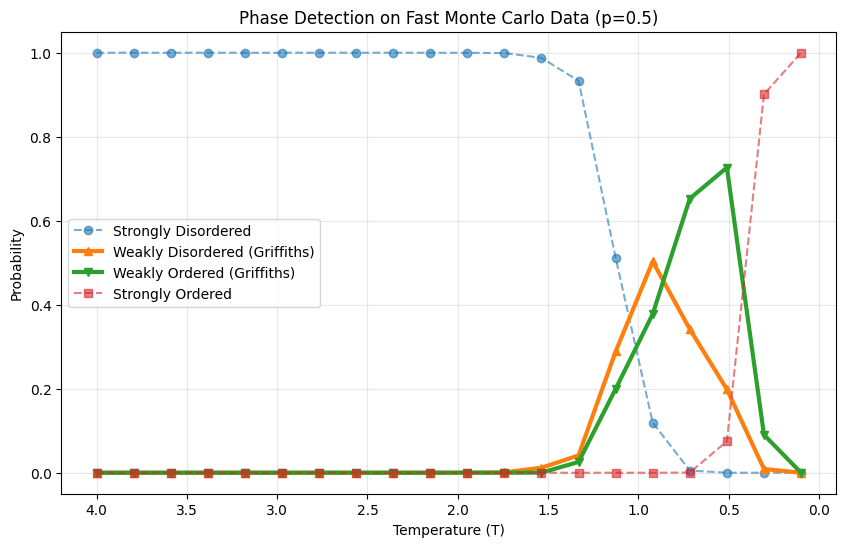

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# --- 1. The Fast Logic (Numba Optimized) ---
@njit(fastmath=True)
def fast_mc_step(spins, J_para, L, Lz, T, delta=0.2):
    N = L * L * Lz
    
    # Perform N spin flips (one Monte Carlo Sweep)
    for _ in range(N):
        # Random Site
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)
        z = np.random.randint(0, Lz)
        
        # Current State
        old_spin = spins[x, y, z].copy()
        
        # Propose Perturbation
        perturbation = np.array([
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta)
        ])
        new_spin = old_spin + perturbation
        # Fast normalization
        norm_val = np.sqrt(np.sum(new_spin**2))
        new_spin = new_spin / norm_val
        
        # Periodic Neighbors
        xp, xm = (x + 1) % L, (x - 1 + L) % L
        yp, ym = (y + 1) % L, (y - 1 + L) % L
        zp, zm = (z + 1) % Lz, (z - 1 + Lz) % Lz
        
        # Neighbor Sums
        nbrs = (spins[xp, y, z] + spins[xm, y, z] + 
                spins[x, yp, z] + spins[x, ym, z])
        nbr_z = spins[x, y, zp] + spins[x, y, zm]
        
        # Energy Change Calculation
        J_local = J_para[z]
        dot_interaction = np.sum((new_spin - old_spin) * nbrs)
        dot_z = np.sum((new_spin - old_spin) * nbr_z)
        
        dE = -J_local * dot_interaction - 1.0 * dot_z
        
        # Metropolis Acceptance
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[x, y, z] = new_spin
            
    return spins

# --- 2. The Class Wrapper ---
class FastLayeredHeisenbergMC:
    def __init__(self, L=10, Lz=10, p_weak=0.0):
        self.L = L
        self.Lz = Lz
        
        # Initialize Random Unit Vectors
        spins = np.random.randn(L, L, Lz, 3)
        norms = np.sqrt(np.sum(spins**2, axis=3, keepdims=True))
        self.spins = spins / norms
        
        # Layered Disorder Setup
        self.J_para = np.ones(Lz)
        if p_weak > 0:
            is_weak = np.random.rand(Lz) < p_weak
            self.J_para[is_weak] = 0.2

    def simulate(self, T, steps=500):
        # We pass the raw numpy arrays to Numba
        current_spins = self.spins
        
        # Run Equilibration + Sampling together
        # Note: We do NOT store history here, solving your MemoryError
        total_steps = steps + 200 # 200 for equilibration
        
        for _ in range(total_steps):
             current_spins = fast_mc_step(current_spins, self.J_para, self.L, self.Lz, T)
             
        self.spins = current_spins
        return self.spins.copy() # Returns only the final (10,10,10,3) array

# --- 3. Run the Simulation (High Speed) ---

L_SIZE = 10
P_WEAK = 0.5
SAMPLES_PER_TEMP = 100 
TEMP_RANGE = np.linspace(4.0, 0.1, 20)

X_real = []
Y_temp = []

print(f"Running Fast Monte Carlo (p={P_WEAK})...")

for T in tqdm(TEMP_RANGE, desc="Temp Sweep"):
    for _ in range(SAMPLES_PER_TEMP):
        sim = FastLayeredHeisenbergMC(L=L_SIZE, Lz=L_SIZE, p_weak=P_WEAK)
        
        # This should now take milliseconds instead of 8 seconds
        final_config = sim.simulate(T=T, steps=500)
        
        X_real.append(final_config)
        Y_temp.append(T)

X_real = np.array(X_real)
Y_temp = np.array(Y_temp)

print("Simulation Complete. Shape:", X_real.shape)

# --- 4. Detect & Plot ---
print("Detecting Phases...")
# Assuming 'model' and 'detect_phases' are already loaded from previous cells
probs = detect_phases(model, X_real)

# Average and Plot
avg_probs_per_T = []
for T in TEMP_RANGE:
    indices = np.where(np.isclose(Y_temp, T))[0]
    avg_probs_per_T.append(np.mean(probs[indices], axis=0))

avg_probs_per_T = np.array(avg_probs_per_T)

plt.figure(figsize=(10, 6))
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 0], label='Strongly Disordered', marker='o', linestyle='--', alpha=0.6)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 1], label='Weakly Disordered (Griffiths)', marker='^', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 2], label='Weakly Ordered (Griffiths)', marker='v', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 3], label='Strongly Ordered', marker='s', linestyle='--', alpha=0.6)

plt.xlabel('Temperature (T)')
plt.ylabel('Probability')
plt.title(f'Phase Detection on Fast Monte Carlo Data (p={P_WEAK})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Running Fast Monte Carlo (p=0.0)...


Temp Sweep: 100%|██████████| 20/20 [15:35<00:00, 46.76s/it]


Simulation Complete. Shape: (2000, 10, 10, 10, 3)
Detecting Phases...


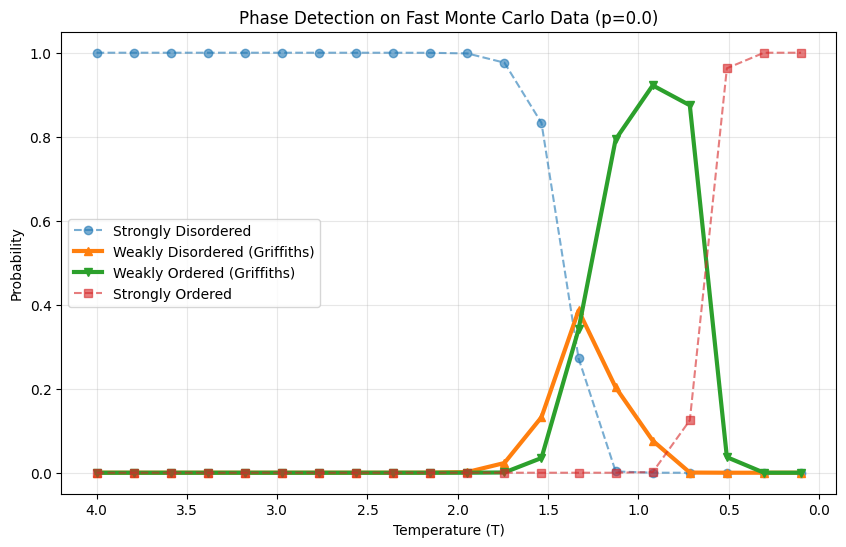

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# --- 1. The Fast Logic (Numba Optimized) ---
@njit(fastmath=True)
def fast_mc_step(spins, J_para, L, Lz, T, delta=0.2):
    N = L * L * Lz
    
    # Perform N spin flips (one Monte Carlo Sweep)
    for _ in range(N):
        # Random Site
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)
        z = np.random.randint(0, Lz)
        
        # Current State
        old_spin = spins[x, y, z].copy()
        
        # Propose Perturbation
        perturbation = np.array([
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta)
        ])
        new_spin = old_spin + perturbation
        # Fast normalization
        norm_val = np.sqrt(np.sum(new_spin**2))
        new_spin = new_spin / norm_val
        
        # Periodic Neighbors
        xp, xm = (x + 1) % L, (x - 1 + L) % L
        yp, ym = (y + 1) % L, (y - 1 + L) % L
        zp, zm = (z + 1) % Lz, (z - 1 + Lz) % Lz
        
        # Neighbor Sums
        nbrs = (spins[xp, y, z] + spins[xm, y, z] + 
                spins[x, yp, z] + spins[x, ym, z])
        nbr_z = spins[x, y, zp] + spins[x, y, zm]
        
        # Energy Change Calculation
        J_local = J_para[z]
        dot_interaction = np.sum((new_spin - old_spin) * nbrs)
        dot_z = np.sum((new_spin - old_spin) * nbr_z)
        
        dE = -J_local * dot_interaction - 1.0 * dot_z
        
        # Metropolis Acceptance
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[x, y, z] = new_spin
            
    return spins

# --- 2. The Class Wrapper ---
class FastLayeredHeisenbergMC:
    def __init__(self, L=10, Lz=10, p_weak=0.0):
        self.L = L
        self.Lz = Lz
        
        # Initialize Random Unit Vectors
        spins = np.random.randn(L, L, Lz, 3)
        norms = np.sqrt(np.sum(spins**2, axis=3, keepdims=True))
        self.spins = spins / norms
        
        # Layered Disorder Setup
        self.J_para = np.ones(Lz)
        if p_weak > 0:
            is_weak = np.random.rand(Lz) < p_weak
            self.J_para[is_weak] = 0.2

    def simulate(self, T, steps=500):
        # We pass the raw numpy arrays to Numba
        current_spins = self.spins
        
        # Run Equilibration + Sampling together
        # Note: We do NOT store history here, solving your MemoryError
        total_steps = steps + 200 # 200 for equilibration
        
        for _ in range(total_steps):
             current_spins = fast_mc_step(current_spins, self.J_para, self.L, self.Lz, T)
             
        self.spins = current_spins
        return self.spins.copy() # Returns only the final (10,10,10,3) array

# --- 3. Run the Simulation (High Speed) ---

L_SIZE = 10
P_WEAK = 0.0
SAMPLES_PER_TEMP = 100 
TEMP_RANGE = np.linspace(4.0, 0.1, 20)

X_real = []
Y_temp = []

print(f"Running Fast Monte Carlo (p={P_WEAK})...")

for T in tqdm(TEMP_RANGE, desc="Temp Sweep"):
    for _ in range(SAMPLES_PER_TEMP):
        sim = FastLayeredHeisenbergMC(L=L_SIZE, Lz=L_SIZE, p_weak=P_WEAK)
        
        # This should now take milliseconds instead of 8 seconds
        final_config = sim.simulate(T=T, steps=500)
        
        X_real.append(final_config)
        Y_temp.append(T)

X_real = np.array(X_real)
Y_temp = np.array(Y_temp)

print("Simulation Complete. Shape:", X_real.shape)

# --- 4. Detect & Plot ---
print("Detecting Phases...")
# Assuming 'model' and 'detect_phases' are already loaded from previous cells
probs = detect_phases(model, X_real)

# Average and Plot
avg_probs_per_T = []
for T in TEMP_RANGE:
    indices = np.where(np.isclose(Y_temp, T))[0]
    avg_probs_per_T.append(np.mean(probs[indices], axis=0))

avg_probs_per_T = np.array(avg_probs_per_T)

plt.figure(figsize=(10, 6))
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 0], label='Strongly Disordered', marker='o', linestyle='--', alpha=0.6)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 1], label='Weakly Disordered (Griffiths)', marker='^', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 2], label='Weakly Ordered (Griffiths)', marker='v', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 3], label='Strongly Ordered', marker='s', linestyle='--', alpha=0.6)

plt.xlabel('Temperature (T)')
plt.ylabel('Probability')
plt.title(f'Phase Detection on Fast Monte Carlo Data (p={P_WEAK})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Running Fast Monte Carlo (p=0.8)...


Temp Sweep: 100%|██████████| 20/20 [26:30<00:00, 79.51s/it] 


Simulation Complete. Shape: (2000, 10, 10, 10, 3)
Detecting Phases...


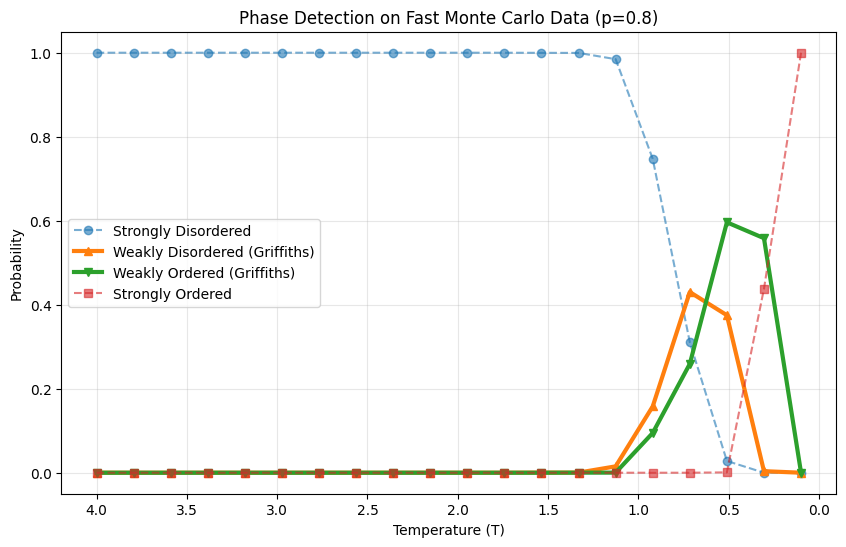

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# --- 1. The Fast Logic (Numba Optimized) ---
@njit(fastmath=True)
def fast_mc_step(spins, J_para, L, Lz, T, delta=0.2):
    N = L * L * Lz
    
    # Perform N spin flips (one Monte Carlo Sweep)
    for _ in range(N):
        # Random Site
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)
        z = np.random.randint(0, Lz)
        
        # Current State
        old_spin = spins[x, y, z].copy()
        
        # Propose Perturbation
        perturbation = np.array([
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta)
        ])
        new_spin = old_spin + perturbation
        # Fast normalization
        norm_val = np.sqrt(np.sum(new_spin**2))
        new_spin = new_spin / norm_val
        
        # Periodic Neighbors
        xp, xm = (x + 1) % L, (x - 1 + L) % L
        yp, ym = (y + 1) % L, (y - 1 + L) % L
        zp, zm = (z + 1) % Lz, (z - 1 + Lz) % Lz
        
        # Neighbor Sums
        nbrs = (spins[xp, y, z] + spins[xm, y, z] + 
                spins[x, yp, z] + spins[x, ym, z])
        nbr_z = spins[x, y, zp] + spins[x, y, zm]
        
        # Energy Change Calculation
        J_local = J_para[z]
        dot_interaction = np.sum((new_spin - old_spin) * nbrs)
        dot_z = np.sum((new_spin - old_spin) * nbr_z)
        
        dE = -J_local * dot_interaction - 1.0 * dot_z
        
        # Metropolis Acceptance
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[x, y, z] = new_spin
            
    return spins

# --- 2. The Class Wrapper ---
class FastLayeredHeisenbergMC:
    def __init__(self, L=10, Lz=10, p_weak=0.0):
        self.L = L
        self.Lz = Lz
        
        # Initialize Random Unit Vectors
        spins = np.random.randn(L, L, Lz, 3)
        norms = np.sqrt(np.sum(spins**2, axis=3, keepdims=True))
        self.spins = spins / norms
        
        # Layered Disorder Setup
        self.J_para = np.ones(Lz)
        if p_weak > 0:
            is_weak = np.random.rand(Lz) < p_weak
            self.J_para[is_weak] = 0.2

    def simulate(self, T, steps=500):
        # We pass the raw numpy arrays to Numba
        current_spins = self.spins
        
        # Run Equilibration + Sampling together
        # Note: We do NOT store history here, solving your MemoryError
        total_steps = steps + 200 # 200 for equilibration
        
        for _ in range(total_steps):
             current_spins = fast_mc_step(current_spins, self.J_para, self.L, self.Lz, T)
             
        self.spins = current_spins
        return self.spins.copy() # Returns only the final (10,10,10,3) array

# --- 3. Run the Simulation (High Speed) ---

L_SIZE = 10
P_WEAK = 0.8
SAMPLES_PER_TEMP = 100 
TEMP_RANGE = np.linspace(4.0, 0.1, 20)

X_real = []
Y_temp = []

print(f"Running Fast Monte Carlo (p={P_WEAK})...")

for T in tqdm(TEMP_RANGE, desc="Temp Sweep"):
    for _ in range(SAMPLES_PER_TEMP):
        sim = FastLayeredHeisenbergMC(L=L_SIZE, Lz=L_SIZE, p_weak=P_WEAK)
        
        # This should now take milliseconds instead of 8 seconds
        final_config = sim.simulate(T=T, steps=500)
        
        X_real.append(final_config)
        Y_temp.append(T)

X_real = np.array(X_real)
Y_temp = np.array(Y_temp)

print("Simulation Complete. Shape:", X_real.shape)

# --- 4. Detect & Plot ---
print("Detecting Phases...")
# Assuming 'model' and 'detect_phases' are already loaded from previous cells
probs = detect_phases(model, X_real)

# Average and Plot
avg_probs_per_T = []
for T in TEMP_RANGE:
    indices = np.where(np.isclose(Y_temp, T))[0]
    avg_probs_per_T.append(np.mean(probs[indices], axis=0))

avg_probs_per_T = np.array(avg_probs_per_T)

plt.figure(figsize=(10, 6))
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 0], label='Strongly Disordered', marker='o', linestyle='--', alpha=0.6)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 1], label='Weakly Disordered (Griffiths)', marker='^', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 2], label='Weakly Ordered (Griffiths)', marker='v', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 3], label='Strongly Ordered', marker='s', linestyle='--', alpha=0.6)

plt.xlabel('Temperature (T)')
plt.ylabel('Probability')
plt.title(f'Phase Detection on Fast Monte Carlo Data (p={P_WEAK})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Running Fast Monte Carlo (p=1)...


Temp Sweep: 100%|██████████| 20/20 [15:38<00:00, 46.93s/it]


Simulation Complete. Shape: (2000, 10, 10, 10, 3)
Detecting Phases...


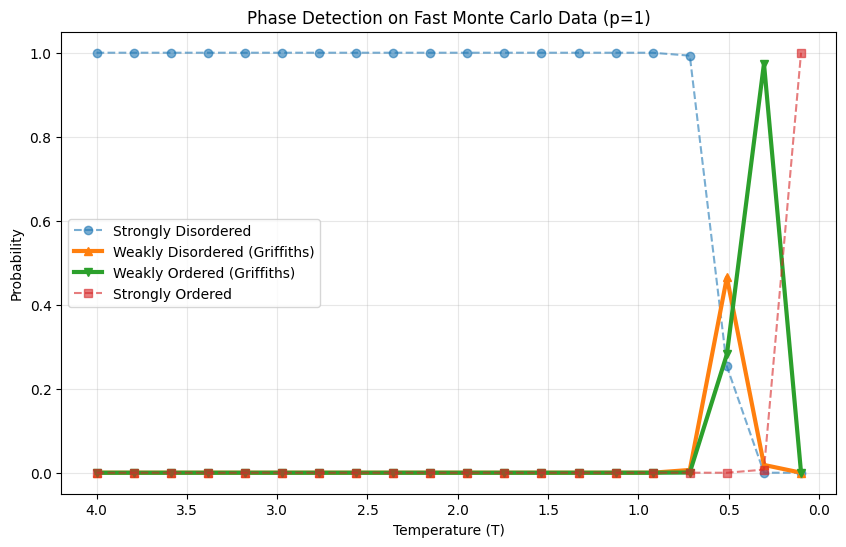

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# --- 1. The Fast Logic (Numba Optimized) ---
@njit(fastmath=True)
def fast_mc_step(spins, J_para, L, Lz, T, delta=0.2):
    N = L * L * Lz
    
    # Perform N spin flips (one Monte Carlo Sweep)
    for _ in range(N):
        # Random Site
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)
        z = np.random.randint(0, Lz)
        
        # Current State
        old_spin = spins[x, y, z].copy()
        
        # Propose Perturbation
        perturbation = np.array([
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta),
            np.random.uniform(-delta, delta)
        ])
        new_spin = old_spin + perturbation
        # Fast normalization
        norm_val = np.sqrt(np.sum(new_spin**2))
        new_spin = new_spin / norm_val
        
        # Periodic Neighbors
        xp, xm = (x + 1) % L, (x - 1 + L) % L
        yp, ym = (y + 1) % L, (y - 1 + L) % L
        zp, zm = (z + 1) % Lz, (z - 1 + Lz) % Lz
        
        # Neighbor Sums
        nbrs = (spins[xp, y, z] + spins[xm, y, z] + 
                spins[x, yp, z] + spins[x, ym, z])
        nbr_z = spins[x, y, zp] + spins[x, y, zm]
        
        # Energy Change Calculation
        J_local = J_para[z]
        dot_interaction = np.sum((new_spin - old_spin) * nbrs)
        dot_z = np.sum((new_spin - old_spin) * nbr_z)
        
        dE = -J_local * dot_interaction - 1.0 * dot_z
        
        # Metropolis Acceptance
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[x, y, z] = new_spin
            
    return spins

# --- 2. The Class Wrapper ---
class FastLayeredHeisenbergMC:
    def __init__(self, L=10, Lz=10, p_weak=0.0):
        self.L = L
        self.Lz = Lz
        
        # Initialize Random Unit Vectors
        spins = np.random.randn(L, L, Lz, 3)
        norms = np.sqrt(np.sum(spins**2, axis=3, keepdims=True))
        self.spins = spins / norms
        
        # Layered Disorder Setup
        self.J_para = np.ones(Lz)
        if p_weak > 0:
            is_weak = np.random.rand(Lz) < p_weak
            self.J_para[is_weak] = 0.2

    def simulate(self, T, steps=500):
        # We pass the raw numpy arrays to Numba
        current_spins = self.spins
        
        # Run Equilibration + Sampling together
        # Note: We do NOT store history here, solving your MemoryError
        total_steps = steps + 200 # 200 for equilibration
        
        for _ in range(total_steps):
             current_spins = fast_mc_step(current_spins, self.J_para, self.L, self.Lz, T)
             
        self.spins = current_spins
        return self.spins.copy() # Returns only the final (10,10,10,3) array

# --- 3. Run the Simulation (High Speed) ---

L_SIZE = 10
P_WEAK = 1
SAMPLES_PER_TEMP = 100 
TEMP_RANGE = np.linspace(4.0, 0.1, 20)

X_real = []
Y_temp = []

print(f"Running Fast Monte Carlo (p={P_WEAK})...")

for T in tqdm(TEMP_RANGE, desc="Temp Sweep"):
    for _ in range(SAMPLES_PER_TEMP):
        sim = FastLayeredHeisenbergMC(L=L_SIZE, Lz=L_SIZE, p_weak=P_WEAK)
        
        # This should now take milliseconds instead of 8 seconds
        final_config = sim.simulate(T=T, steps=500)
        
        X_real.append(final_config)
        Y_temp.append(T)

X_real = np.array(X_real)
Y_temp = np.array(Y_temp)

print("Simulation Complete. Shape:", X_real.shape)

# --- 4. Detect & Plot ---
print("Detecting Phases...")
# Assuming 'model' and 'detect_phases' are already loaded from previous cells
probs = detect_phases(model, X_real)

# Average and Plot
avg_probs_per_T = []
for T in TEMP_RANGE:
    indices = np.where(np.isclose(Y_temp, T))[0]
    avg_probs_per_T.append(np.mean(probs[indices], axis=0))

avg_probs_per_T = np.array(avg_probs_per_T)

plt.figure(figsize=(10, 6))
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 0], label='Strongly Disordered', marker='o', linestyle='--', alpha=0.6)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 1], label='Weakly Disordered (Griffiths)', marker='^', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 2], label='Weakly Ordered (Griffiths)', marker='v', linewidth=3)
plt.plot(TEMP_RANGE, avg_probs_per_T[:, 3], label='Strongly Ordered', marker='s', linestyle='--', alpha=0.6)

plt.xlabel('Temperature (T)')
plt.ylabel('Probability')
plt.title(f'Phase Detection on Fast Monte Carlo Data (p={P_WEAK})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()